In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import sys
sys.path.append('..')
import TFUtil
%load_ext autoreload
%autoreload 2

In [6]:
NEG_INF = -float("inf")

def logsumexp(*args):  # summation in linear space -> LSE in log-space
    """
    Stable log sum exp.
    """
    if all(a == NEG_INF for a in args):
        return NEG_INF
    a_max = max(args)
    lsp = np.log(sum(np.exp(a - a_max)
                   for a in args))
    return a_max + lsp


def log_softmax(acts, axis=None):
    """computes log(softmax(x, axis)) in a numerical stable way."""
    assert axis is not None
    a = acts - np.max(acts, axis=axis, keepdims=True)  # normalize for stability
    probs = np.sum(np.exp(a), axis=axis, keepdims=True)
    log_probs = a - np.log(probs)
    return log_probs

In [108]:
def draw_dot_grid(max_time, max_target, t, u):
    plt.rcParams["figure.figsize"] = (20,10)
    plt.rcParams["axes.labelsize"] = 20
    plt.rcParams["xtick.labelsize"] = 20
    plt.rcParams["ytick.labelsize"] = 20
    
    fig, ax = plt.subplots()
    plt.gca().invert_yaxis()
    ax.xaxis.set_label_position('top')
    
    marker_style = dict(color='tab:blue',linestyle='', marker='o',
                        markersize=15, markerfacecoloralt='tab:red')
    for y in range(max_time):
        ax.plot(y*np.ones(max_target), **marker_style)
    for n in range(1, max_time+max_target-3):
        ax.plot([n, 0],[0, n], color='tab:green', linestyle=':')
        ax.text(n-0.5, 0.5, 'n=%d' % (n-1), color='tab:green', fontsize=20)
    ax.plot(u, t, marker='o', color='tab:red')
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_label_position('left')
    ax.tick_params(axis='x', top=True, labeltop=True)
    ax.tick_params(axis='y', left=True, labelright=True)
    
    ax.set(xlabel='label (U)', ylabel='time (T)')

In [109]:
n_batch = 8
n_vocab = 5
max_target = 3
max_input = 8
np.random.seed(42)
labels = np.random.randint(1, n_vocab, (n_batch, max_target-1))
input_lengths = np.random.randint(1, max_input, (n_batch,), dtype=np.int32)
# TODO: max_target-1?
label_lengths = np.random.randint(1, max_target-1, (n_batch,), dtype=np.int32)
#input_lengths = np.array([2], dtype=np.int32)
#label_lengths = np.array([1], dtype=np.int32)
acts = np.random.normal(0, 1, (n_batch, max_input, max_target, n_vocab))
log_probs = log_softmax(acts, axis=3)  # along vocabulary for (B, T, U, V)

In [110]:
from ref_transduce import forward_pass
from rnnt_tf_impl import numpy_forward as forward_pass_debug
i = 4
alphas, ll_forward = forward_pass_debug(log_probs[i][:input_lengths[i], :label_lengths[i]+1], labels[i], blank_index=0, debug=True)

U=2, T=2, V=5
t= 1 u= 1: LSE(-2.531 + -1.676, -2.632 +  -1.439) = LSE(-4.207, -4.070) = -3.443
Alpha matrix: (2, 2)
[[ 0.         -2.53055754]
 [-2.63160912 -3.44300469]]
log-posterior = alpha[1, 1] + log_probs[1, 1, 0] = -3.443 + -2.492 = -5.9351


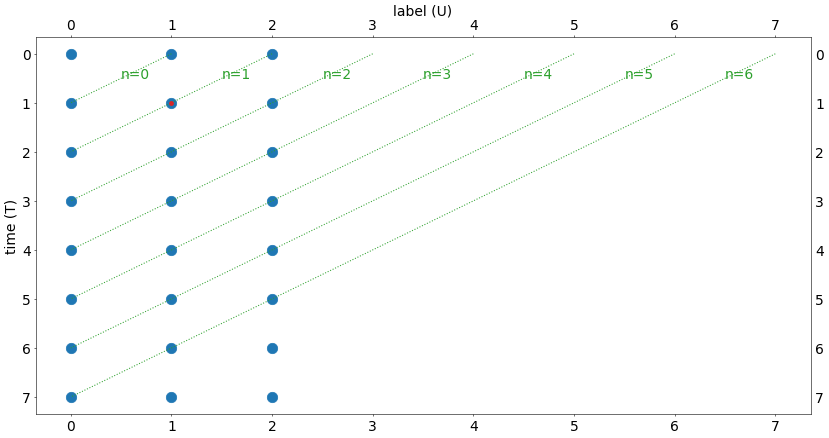

In [114]:
draw_dot_grid(max_time=max_input, max_target=max_target, t=input_lengths[i]-1, u=label_lengths[i])